In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

##Giải nén Dataset

In [3]:
zip_path = "/content/drive/MyDrive/CIFAR10_CNN/cifar10.zip"
destination_path = "/content/cifar10.zip"

# Sao chép tệp từ Google Drive vào thư mục hiện tại
!cp "{zip_path}" "{destination_path}"

# Giải nén tệp
!unzip -q "{destination_path}" -d "/content/"


## Đường dẫn tới tập train ,val,test

In [4]:
train_path = "/content/cifar10/train"
val_path = "/content/cifar10/val"
test_path = "/content/cifar10/test"

## Show thử các ảnh trong các tập

In [5]:
def show_image(dataset_path):
    image_list = []
    for folder in os.listdir(dataset_path):
        image_path = os.path.join(os.path.join(dataset_path,folder),os.listdir(os.path.join(dataset_path,folder))[0])
        #opencv2 đọc ảnh dạng BGR
        image_list.append([cv2.imread(image_path),folder])
    plt.subplots(figsize =(10,10))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image_list[i][0])
        plt.xlabel(image_list[i][1])
    plt.show()

<ipython-input-5-7e57366e8805>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,i+1)


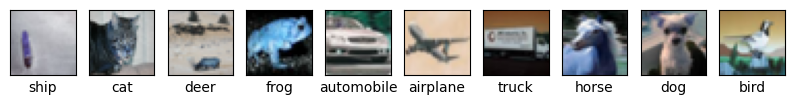

In [6]:
show_image(train_path)

<ipython-input-5-7e57366e8805>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,i+1)


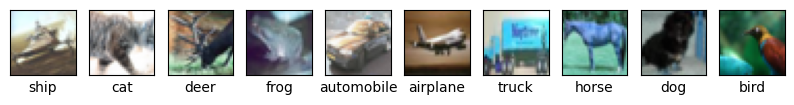

In [7]:
show_image(val_path)

<ipython-input-5-7e57366e8805>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,i+1)


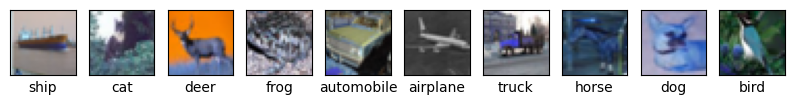

In [8]:
show_image(test_path)

##Augment data

In [9]:
train_datagen = ImageDataGenerator(
    #tăng giảm độ sáng
    brightness_range =[0.5 ,1.5],
    #dịch ảnh theo chiều rộng
    # Với giá trị <= 1 ví dụ ảnh mình có chiều rộng 100 px dùng 0.2 tức là dịch ngẫu nhiên ảnh (-20, 20)
    # Với giá trị > 1 thì ví dụ điền số 2 thì nó [-1, 0, 1]
    width_shift_range = 0.2 ,
    height_shift_range = 0.2,
    #lật ngược ảnh
    horizontal_flip = True ,
    #phóng to ảnh
    zoom_range = [0.7 ,1.2 ],
    #chuẩn hóa
    rescale = 1./255
)
#test không augment ,val cũng thường không augment
val_datagen= ImageDataGenerator(
    rescale = 1./255
)

In [10]:
#mỗi folder con bên trong folder lớn mà mình đưa vào hàm "flow_from_directory" thì nó coi là 1 class
train_data = train_datagen.flow_from_directory(train_path,target_size =(32,32),batch_size = 32,class_mode = "categorical")
val_data = val_datagen.flow_from_directory(val_path , target_size =(32,32),batch_size = 32 ,class_mode = "categorical")

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.


##CNN

In [19]:
def CNN(image_shape = (32, 32, 3)):
  input = Input(shape = image_shape)
  # Đầu vào (32, 32, 3)
  # Output size = (Input size + 2*padding - kernel_size)/strides + 1
  # Width_out = (32 + 2*1 - 3)/1 + 1 = 32
  # Height_out = 32
  # Khi bước nhảy của cửa sổ trượt bằng 1 và padding ở dạng same thì size output = size input
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(input)
  # Kết quả đầu ra của dòng 6 sẽ có kích cỡ (32, 32, 32)
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(256, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)

  x = Dense(128, activation = "relu")(x)
  x = Dropout(0.2)(x)

  output = Dense(10, activation = "softmax")(x)
  model = Model(inputs = input, outputs = output)
  model.summary()

  return model


In [20]:
model = CNN()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                             

In [26]:
model.compile(loss = "categorical_crossentropy",optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),metrics = ["accuracy"])
#factor = lr mới = lr cũ * factor
my_callback = [ReduceLROnPlateau(min_lr = 0.00001,factor = 0.1,patience = 10,monitor = "val_loss"),ModelCheckpoint("/content/drive/MyDrive/CIFAR10_CNN/Good_model_CNN_{val_loss:}_{val_accuracy:}.hdf5",monitor="val_accuracy",save_best_only = True)]

steps_per_epoch = 32000 /64
validation_step = 8000/64
history = model.fit(train_data,batch_size = 64,epochs = 10,validation_data =val_data,steps_per_epoch = steps_per_epoch,validation_steps = validation_step,callbacks = my_callback)




Epoch 1/10
500/500 [==============================] - 166s 325ms/step - loss: 1.2092 - accuracy: 0.5676 - val_loss: 1.0474 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 163s 326ms/step - loss: 1.1896 - accuracy: 0.5795 - val_loss: 1.0781 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 160s 321ms/step - loss: 1.1817 - accuracy: 0.5824 - val_loss: 0.9965 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 164s 328ms/step - loss: 1.1438 - accuracy: 0.5950 - val_loss: 0.9448 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 160s 320ms/step - loss: 1.1305 - accuracy: 0.6036 - val_loss: 0.9999 - val_accuracy: 0.6499 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 163s 325ms/step - loss: 1.1141 - accuracy: 0.6044 - val_loss: 1.1195 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 7/10
500/500 [==========================

In [27]:
model = load_model("/content/drive/MyDrive/CIFAR10_CNN/Good_model_CNN_0.8760263323783875_0.6894999742507935.hdf5")

In [28]:
test_data = val_datagen.flow_from_directory(test_path,target_size =(32,32),batch_size = 32,class_mode = "categorical")
model.evaluate(test_data)

Found 10000 images belonging to 10 classes.
313/313 [==============================] - 25s 80ms/step - loss: 0.8728 - accuracy: 0.6893


[0.8727762699127197, 0.689300000667572]

##NN Network

In [29]:
def NN(shape_image = (32,32,3)):
    input = Input(shape = shape_image)
    x = Flatten()(input)
    x = Dense(256,activation = "relu")(x)
    x = Dropout(0.2)(x)

    x = Dense(128,activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64,activation ="relu")(x)
    x = Dropout(0.2)(x)

    output = Dense(10,activation = "softmax")(x)
    model = Model(inputs = input, outputs = output)
    model.summary()
    return model

In [30]:
model = NN()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256

In [37]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.0000001), ModelCheckpoint("/content/drive/MyDrive/CIFAR10_CNN/Good-model_{val_loss:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]
steps_per_epoch = 32000/32
validation_step = 8000/32
history = model.fit(train_data, batch_size=32, epochs = 10, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

Epoch 1/10
1000/1000 [==============================] - 55s 54ms/step - loss: 1.9917 - accuracy: 0.2629 - val_loss: 1.8489 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - 52s 52ms/step - loss: 1.9997 - accuracy: 0.2592 - val_loss: 1.8594 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - 53s 53ms/step - loss: 1.9930 - accuracy: 0.2608 - val_loss: 1.8986 - val_accuracy: 0.3086 - lr: 0.0010
Epoch 4/10
1000/1000 [==============================] - 51s 51ms/step - loss: 1.9975 - accuracy: 0.2597 - val_loss: 1.8706 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 5/10
1000/1000 [==============================] - 53s 53ms/step - loss: 1.9960 - accuracy: 0.2602 - val_loss: 1.8734 - val_accuracy: 0.3254 - lr: 0.0010
Epoch 6/10
1000/1000 [==============================] - 51s 51ms/step - loss: 1.9972 - accuracy: 0.2635 - val_loss: 1.8551 - val_accuracy: 0.3322 - lr: 0.0010
Epoch 7/10
1000/1000 [========================

In [38]:
model = load_model("/content/drive/MyDrive/CIFAR10_CNN/Good-model_1.859406590461731_0.3409999907016754.hdf5")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256

In [39]:
test_data = val_datagen.flow_from_directory(test_path,target_size = (32,32),batch_size = 32,class_mode = "categorical")

Found 10000 images belonging to 10 classes.


In [40]:
model.evaluate(test_data)

313/313 [==============================] - 6s 19ms/step - loss: 1.8470 - accuracy: 0.3427


[1.8470293283462524, 0.3427000045776367]